# Training Facemask Detection CNN for DPU compilation

In this notebook we show how to train a simple Convolutional Neural Network (CNN)
on the  for deployment on the DPU (ZCU104). We will cover:

* Loading and pre-processing the imagenet dataset
* Training a CNN with Keras and Tensorflow
* Freezing the trained model
* Quantizing and evaluating the quantized model
* Compiling for DPU using the Vitis AI compiler

**Note**:
* This notebook should be run on a proper X86 machine

In my case:
    * Distributor ID:	Ubuntu
    * Description:	Ubuntu 20.04.1 LTS
    * Release:	20.04

AVX2 and FMA instructions sets. To check:
```shell
grep avx2 /proc/cpuinfo
grep fma /proc/cpuinfo
```
* Please make sure the following has been done in terminal before you start this notebook:
```shell
conda activate vitis-ai-tensorflow
yes | pip install matplotlib keras==2.2.5
```

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import keras
from keras.layers import Dense, Conv2D, InputLayer, Flatten, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-e9nfvssh because the default path (/home/jetbot/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.
Using TensorFlow backend.


## Download dataset

The Facemask dataset comes with 1916 images with Facemask and 1948 without Facemask.

In [1]:
!git clone https://github.com/altaga/Facemask-Dataset

Cloning into 'Facemask-Dataset'...
Updating files:  27% (1067/3849)
Updating files:  28% (1078/3849)
Updating files:  29% (1117/3849)
Updating files:  30% (1155/3849)
Updating files:  31% (1194/3849)
Updating files:  32% (1232/3849)
Updating files:  33% (1271/3849)
Updating files:  34% (1309/3849)
Updating files:  35% (1348/3849)
Updating files:  36% (1386/3849)
Updating files:  37% (1425/3849)
Updating files:  38% (1463/3849)
Updating files:  39% (1502/3849)
Updating files:  40% (1540/3849)
Updating files:  41% (1579/3849)
Updating files:  42% (1617/3849)
Updating files:  43% (1656/3849)
Updating files:  44% (1694/3849)
Updating files:  45% (1733/3849)
Updating files:  46% (1771/3849)
Updating files:  47% (1810/3849)
Updating files:  48% (1848/3849)
Updating files:  49% (1887/3849)
Updating files:  50% (1925/3849)
Updating files:  51% (1963/3849)
Updating files:  52% (2002/3849)
Updating files:  53% (2040/3849)
Updating files:  54% (2079/3849)
Updating files:  55% (2117/3849)
Updating

## Load dataset

The Facemask dataset comes with 1916 images with Facemask and 1948 without Facemask. We have to preprocess the images.

In [2]:
print("The number of images with facemask labelled 'yes':",len(os.listdir('Facemask-Dataset/facemask-dataset/yes')))
print("The number of images without facemask labelled 'no':",len(os.listdir('Facemask-Dataset/facemask-dataset/no')))

The number of images with facemask labelled 'yes': 1916
The number of images without facemask labelled 'no': 1930


## Preprocessing Dataset

We are going to preprocess the images, convert them to grayscale, transform their size to 64x64, divide the images by 255 to normalize them, and convert them to numpy float32 arrays.

In [3]:
import cv2
import os

data = []
labels = []

mylist = os.listdir("Facemask-Dataset/facemask-dataset") # Set Dataset Folder

for x in mylist:
    mylist2 = os.listdir("Facemask-Dataset/facemask-dataset/"+str(x))
    label = str(x)
    for y in mylist2:
        # extract the class label from the folder name

        # load the input image (64x64) and preprocess it
        image = load_img("Facemask-Dataset/facemask-dataset/"+str(x)+"/"+str(y),grayscale=True, target_size=(64, 64))
        image = img_to_array(image)
        image = preprocess_input(image)

        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing

(x_train, x_test,y_train, y_test) = train_test_split(data, labels,
                                                        test_size=0.20, stratify=labels, random_state=42)

print('Training data: {}, {}'.format(x_train.shape, y_train.shape))
print('Test data: {}, {}'.format(x_test.shape, y_test.shape))


#The strcuture that we must obtain are the following:
#     For training and test datasets: (#data, 64, 64, 1)
#     For labels: (#labels, 2)
   
#Example:
#Training data: (3091, 64, 64, 1), (3091, 2)
#Test data: (773, 64, 64, 1), (773, 2)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Training data: (3076, 64, 64, 1), (3076, 2)
Test data: (770, 64, 64, 1), (770, 2)


## Let's check if the data set and labels are correct with a sample of 6 images

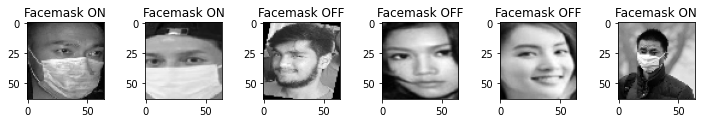

In [4]:
SampleSize=6
fig, axs = plt.subplots(1, SampleSize, figsize=(10, 10))
plt.tight_layout()

for i in range(SampleSize):
    axs[i].imshow(x_train[i].reshape(64, 64), 'gray')
    if(y_train[i][0]==0):
        tempLabel = "Facemask ON"
    else:
        tempLabel = "Facemask OFF"
    axs[i].set_title('{}'.format(tempLabel))

## Model Creation

Create a sequential model by passing a list of layers. Because the mask detection it 
is a binary classification problem, we can use 2 Convolutional layers to solve the problem.

# NOTE: Do not rename the input layer nor the output layer.


In [5]:
model = keras.models.Sequential([
    InputLayer(input_shape=(64, 64, 1), name='input_data'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax', name='output_logits')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1605696   
_________________________________________________________________
output_logits (Dense)        (None, 2)                 130       
Total para

Configure the model for training: choose desired optimizer, loss function
and metrics to observe over the training period.

In [7]:
model.compile(optimizer='adam',
              loss="binary_crossentropy", # For binary classifiers always use binary_crossentropy
              metrics=['accuracy'])

# Early stoping to avoid Overfitting

In [8]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1)

Now we can train the model.

In [9]:
history = model.fit(x_train,y_train,validation_data=(x_test, y_test),epochs=30, verbose=1 ,callbacks=[es])

Train on 3076 samples, validate on 770 samples
Epoch 1/30
3076/3076 [==============================] - 41s 13ms/step - loss: 0.5043 - acc: 0.7415 - val_loss: 0.3060 - val_acc: 0.8688
Epoch 2/30
3076/3076 [==============================] - 17s 5ms/step - loss: 0.2800 - acc: 0.8771 - val_loss: 0.2305 - val_acc: 0.8922
Epoch 3/30
3076/3076 [==============================] - 17s 5ms/step - loss: 0.1973 - acc: 0.9197 - val_loss: 0.1934 - val_acc: 0.9221
Epoch 4/30
3076/3076 [==============================] - 17s 5ms/step - loss: 0.1514 - acc: 0.9376 - val_loss: 0.1878 - val_acc: 0.9299
Epoch 5/30
3076/3076 [==============================] - 17s 5ms/step - loss: 0.1040 - acc: 0.9662 - val_loss: 0.1526 - val_acc: 0.9338
Epoch 6/30
3076/3076 [==============================] - 17s 5ms/step - loss: 0.0782 - acc: 0.9711 - val_loss: 0.1595 - val_acc: 0.9364
Epoch 00006: early stopping


We can inspect the training results by plotting the collected data in the
`history` object.

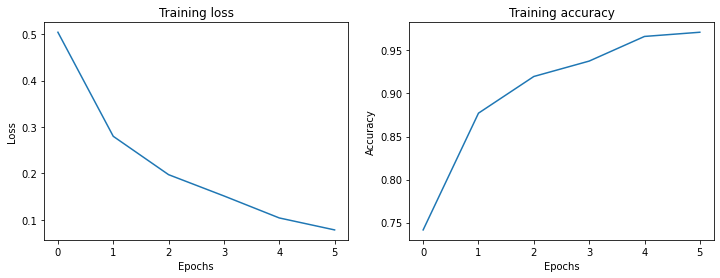

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history.history['loss'])
axs[0].set_title('Training loss')
axs[0].set(xlabel='Epochs', ylabel='Loss')

axs[1].plot(history.history['acc'])
axs[1].set_title('Training accuracy')
axs[1].set(xlabel='Epochs', ylabel='Accuracy')
plt.show()

In [11]:
loss, accuracy = model.evaluate(x_test,y_test)
print("Test loss: {}".format(loss))
print("Test accuracy: {}".format(accuracy))

770/770 [==============================] - 1s 2ms/step
Test loss: 0.15947228929618684
Test accuracy: 0.9363636363636364


Evaluate the trained model on the test dataset.

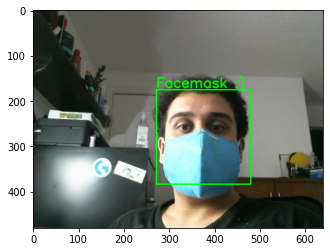

FPS:  90.7777500623597


In [ ]:
%matplotlib inline
import time
import pylab as plt
from IPython import display
%matplotlib inline 
from matplotlib import pyplot as plt
import struct
import time

# initialize camera from OpenCV
import cv2

videoIn = cv2.VideoCapture(0)
    
while(str(videoIn.isOpened())=="False"):
    videoIn = cv2.VideoCapture(0)
print("Capture device is open")

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while 1:
    ret, frame = videoIn.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    marker = 0
    for (x,y,w,h) in faces:
        if(w>109):
            start_time = time.time()
            raw_data = []
            roi_gray = gray[y:y+h, x:x+w]
            roi_gray = cv2.resize(roi_gray, (64,64), interpolation = cv2.INTER_AREA)
            roi_gray = roi_gray/255.0
            raw_data.append(roi_gray)
            raw_data = np.array(raw_data, dtype="float32")
            raw_data = np.expand_dims(raw_data, axis=3)
             # start time of the loop
            softmax =  model.predict(raw_data)
            prediction = softmax.argmax()
            print("FPS: ", 1.0 / (time.time() - start_time))
            if(prediction):
                frame = cv2.putText(frame, str("Facemask :)"), (x,y-5),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
                cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
            else:
                frame = cv2.putText(frame, str("Facemask X"), (x,y-5),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
                cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)

    plt.imshow(frame[:,:,[2,1,0]])
    display.clear_output(wait=True)
    plt.show()